## 1. Load packages

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import csv
from itertools import zip_longest
from dataclasses import dataclass
import platform
import glob
import shutil
from pathlib import Path
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,Rescaling,Dropout,Activation
from sklearn.metrics import accuracy_score

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

print(keras.__version__)
print(tf.__version__)

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

## 2. Set dataset and training parameters

In [2]:
@dataclass
class TrainingConfig:
    BATCH_SIZE: int = 64
    EPOCHS: int = 20
    LEARNING_RATE: float = 0.001


@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"/kaggle/working/"
    DATA_SHAPE: tuple = (64,64, 3)
    NUM_CLASSES: int = 43

## 3. Load training and validation data

In [3]:
# Read the Train.csv file with pandas
training_images_csv_path = "/kaggle/input/gtsrb-dataset/GTSRB/Train.csv"
train_csv = pd.read_csv(training_images_csv_path)

data_root = "/kaggle/input/gtsrb-dataset/GTSRB/"
images = []

# Reshape and store each images of the training dataset in a list called "images"
for image_path in train_csv["Path"]:
    path = os.path.join(data_root, image_path)
    
    if os.path.exists(path):
        image = Image.open(path)
        image = image.resize([DatasetConfig.DATA_SHAPE[0],DatasetConfig.DATA_SHAPE[1]])
        images.append(image)
    
    else:
        print("The image "+image_path+" does NOT exist in the folder "+data_root)
        

# Store all the labels of the training dataset in a list called "labels"
labels =  train_csv["ClassId"]


print("Total number of images : ",len(images))
print("Total number of labels : ",len(labels))

Total number of images :  39209
Total number of labels :  39209


In [5]:
# We need to convert the PIL images to numpy arrays to later convert it to tensors. 
# This is because we can not convert PIL image to tensor directly.
images = np.array(images)
labels = np.array(labels)

# Split the training dataset into training and validation data with a 80% training and 20% validation ratio and shuffle the data
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Convert to tensor for training
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_valid = tf.convert_to_tensor(X_valid, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_valid = tf.convert_to_tensor(y_valid, dtype=tf.float32)

print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(31367, 64, 64, 3) (31367,)
(7842, 64, 64, 3) (7842,)


## 4. Plot function 

In [5]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

## 5. Create CNN model and training function

In [8]:
def get_model_from_scratch(num_classes, input_shape):

    dp_value = 0.1
    kernel_size = 7
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    
    x = Conv2D(8, kernel_size, padding='valid')(x) 
    x = Conv2D(16, kernel_size, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)    

    x = Conv2D(32, kernel_size, padding='valid')(x)
    x = Conv2D(64, kernel_size, padding='valid')(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D()(x)   
    
    # Flatten the feature maps
    flattened = Flatten()(x) 
    
    x = Dense(480, activation='relu')(flattened)           
    x = Dropout(dp_value)(x)
    x = Dense(240, activation='relu')(x)
    x = Dropout(dp_value)(x)
    x = Dense(120, activation='relu')(x)
    x = Dropout(dp_value)(x)
    x = Dense(84, activation='relu')(x)  
    x = Dropout(dp_value)(x)
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='Model_1')
    
    return model

In [9]:
def train_model(dataset_config=DatasetConfig(),training_config=TrainingConfig(),print_summary=True):

    # Create the model by passing the number of classes and data shape
    model = get_model_from_scratch(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # Optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() 

    # Compile model
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

    # Print the model summary
    if print_summary:
        model.summary()

    # Train the model
    training_results = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=training_config.EPOCHS, callbacks=callbacks)

    print("training_results keys:", training_results.history.keys())

    return model, training_results

## 6. Train the model

In [11]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    
    # Start training
    trained_model, training_results = train_model(dataset_config=DatasetConfig(),training_config=training_config)

Number of devices: 2


Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 58, 58, 8)           │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 52, 52, 16)          │           6,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 52, 52, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 32)          │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 480)                 │       1,505,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 240)                 │         115,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │          28,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,796,947 (6.85 MB)

 Trainable params: 1,796,947 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.4869 - loss: 1.9205 - val_accuracy: 0.9301 - val_loss: 0.3260
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9461 - loss: 0.2121 - val_accuracy: 0.9398 - val_loss: 0.2221
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9554 - loss: 0.1943 - val_accuracy: 0.9768 - val_loss: 0.0756
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9750 - loss: 0.1109 - val_accuracy: 0.9847 - val_loss: 0.0662
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9752 - loss: 0.1177 - val_accuracy: 0.9901 - val_loss: 0.0430
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9790 - loss: 0.1025 - val_accuracy: 0.9885 - val_loss: 0.0520
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9794 - loss: 0.1169 - val_accuracy: 0.9832 - val_loss: 0.0862
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9871 - loss: 0.0733 - 

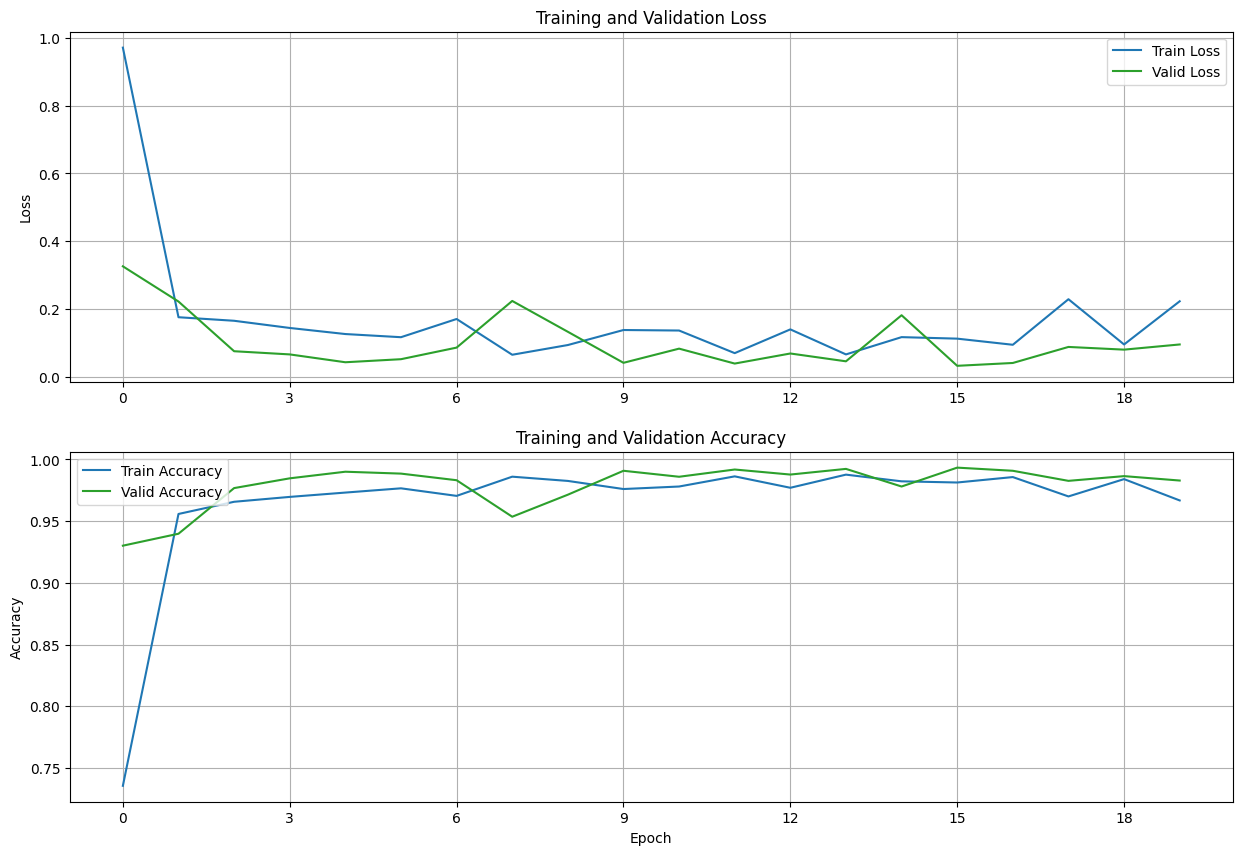

In [12]:
#Plot Loss and Accuracy graph for training

loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper right",
    acc_legend_loc="upper left",
)

## 7. Evaluate the model on Test images

In [16]:
# Importing the test dataset
y_test = pd.read_csv('/kaggle/input/gtsrb-dataset/GTSRB/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Open a strategy scope.
with strategy.scope():
    for img in imgs:
        image = Image.open('/kaggle/input/gtsrb-dataset/GTSRB/'+img)
        image = image.resize([DatasetConfig.DATA_SHAPE[0],DatasetConfig.DATA_SHAPE[1]])
        data.append(np.array(image))

X_test=np.array(data)

# Open a strategy scope.
with strategy.scope():

    # Make prediction on the test images
    pred = np.argmax(trained_model.predict(X_test), axis=-1)

#Accuracy on the test images
print(accuracy_score(labels, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
0.9440221694378464
